# **Pix2Pix GAN**

#### Data labeling : **Photoshop edge dectaction** or **Open CV edge detaction algorithms**
#### Input : 512 x 256 x 3(real data + sketch data)
#### Output : 256 X 256 X 3

[Source code : Tensorflow Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko)







## 1. Module, Data Path, Data parameters

In [7]:
# Google drive mount
from google.colab import drive
drive.mount("./mount")

# Module import

import tensorflow as tf # Tensorflow framework
import os # access and modify the path variables to save checkpoints
import time # display time
from matplotlib import pyplot as plt # show image

# Change PATH variable to absolute/ relative path to the images directory on your machine which contains the train and val folders
PATH_train = "mount/My Drive/Colab Notebooks/digigo_data/gan_mountain/train"
PATH_val = "mount/My Drive/Colab Notebooks/digigo_data/gan_mountain/val"
PATH_test = "mount/My Drive/Colab Notebooks/digigo_data/gan_mountain/test"
PATH_hand = "mount/My Drive/Colab Notebooks/digigo_data/gan_mountain/hand"

# Change these variables as per your need
EPOCHS = 50
BUFFER_SIZE = 14224
BATCH_SIZE = 4
IMG_WIDTH = 256
IMG_HEIGHT = 256

Mounted at ./mount


## 2. Preprocessing

In [8]:
def load(image_file): # load and split image into real data, sketch data
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image, channels = 3)

    w = tf.shape(image)[1]

    w = w // 2 
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

def resize(input_image, real_image, height, width): # return the images as 256 x 256 pixel
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image, real_image): # return cropped input and output images
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

def normalize(input_image, real_image): # normalize images to [-1, 1]
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image): # get horizontally flipped images 
    input_image, real_image = resize(input_image, real_image, 256, 256)
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

In [10]:
# Train image data
def load_image_train(image_file): # return processed image
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image
    
train_dataset = tf.data.Dataset.list_files(PATH_train+'*/*') # collect the path to all files
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE) # shuffled using the buffer_size and divided into mini-batchs

# validation image data
def load_image_val(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image
  
val_dataset = tf.data.Dataset.list_files(PATH_val+'*/*')
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

# test image data
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image
  
test_dataset = tf.data.Dataset.list_files(PATH_test+'*/*')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

# sketch image data
def load_image_hand(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image
  
hand_dataset = tf.data.Dataset.list_files(PATH_hand+'*/*')
hand_dataset = hand_dataset.map(load_image_hand)
hand_dataset = hand_dataset.batch(BATCH_SIZE)

## 3. Modeling 

### 3.1 Generator : create fake images

In [11]:
# The Generator model is a UNet Architecture and has skip connection

OUTPUT_CHANNELS = 3

def downsample(filters, size, shape, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', batch_input_shape=shape, 
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, size, shape, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2, batch_input_shape=shape,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

def buildGenerator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, (None, 256, 256, 3), apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4, (None, 128, 128, 64)), # (bs, 64, 64, 128)
        downsample(256, 4, (None, 64, 64, 128)), # (bs, 32, 32, 256)
        downsample(512, 4, (None, 32, 32, 256)), # (bs, 16, 16, 512)
        downsample(512, 4, (None, 16, 16, 512)), # (bs, 8, 8, 512)
        downsample(512, 4, (None, 8, 8, 512)), # (bs, 4, 4, 512)
        downsample(512, 4, (None, 4, 4, 512)), # (bs, 2, 2, 512)
        downsample(512, 4, (None, 2, 2, 512)), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, (None, 1, 1, 512), apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, (None, 2, 2, 1024), apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, (None, 4, 4, 1024), apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4, (None, 8, 8, 1024)), # (bs, 16, 16, 1024)
        upsample(256, 4, (None, 16, 16, 1024)), # (bs, 32, 32, 512)
        upsample(128, 4, (None, 32, 32, 512)), # (bs, 64, 64, 256)
        upsample(64, 4, (None, 64, 64, 256)), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

generator = buildGenerator()

In [12]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  131584      ['sequential[0][0]']             
                                                                                              

### 3.2 Discriminator : Classify real and fake images

In [13]:
def downs(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', 
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def buildDiscriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downs(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downs(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downs(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  
discriminator = buildDiscriminator()

In [14]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 target_image (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']     

### 3.2 Loss Functions

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

LAMBDA = 100

# BCE + L1 Regularization
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

# BCE
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

### 3.4 Optimizers

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### 3.5 Creating Checkpoints

In [ ]:
checkpoint_dir = './Sketch2Color_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### 3.6 Displaying image

In [ ]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

### 3.7 Logging the loss

In [ ]:
import datetime
log_dir="Sketch2Coloe_logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

## 4. Train step

#### 1. Generator outputs a prediction
#### 2. Discriminator is desinged to have 2 inputs at a time
##### -->  first time  : sketch image & generated image
##### -->  next time : real image & generated image
##### 3. Losses are calculated
##### 4. Gradients are calculated from the losses

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [ ]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)

        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            train_step(input_image, target, epoch)
        print()

#        Chech point
#        if (epoch + 1) % 5 == 0:
#            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
#    checkpoint.save(file_prefix = checkpoint_prefix)

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)

In [ ]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## 5. Result

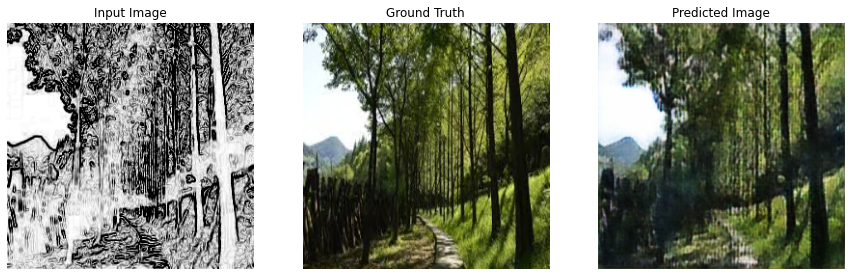

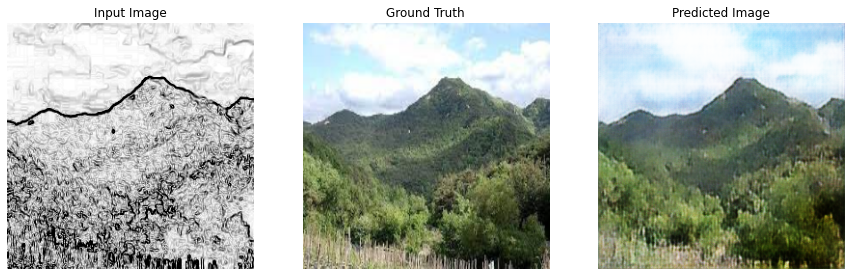

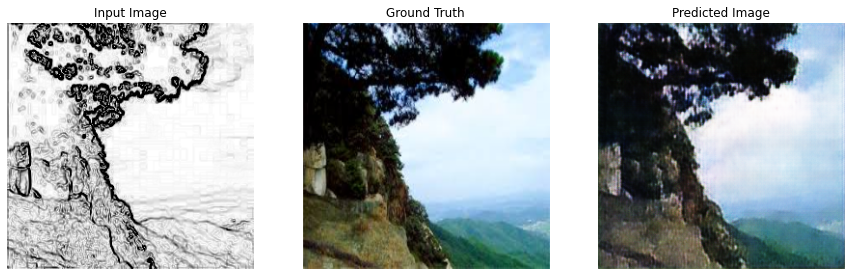

In [ ]:
for example_input, example_target in train_dataset.take(3):
    generate_images(generator, example_input, example_target)

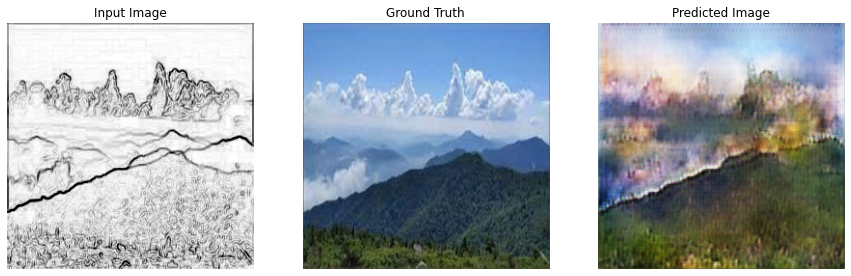

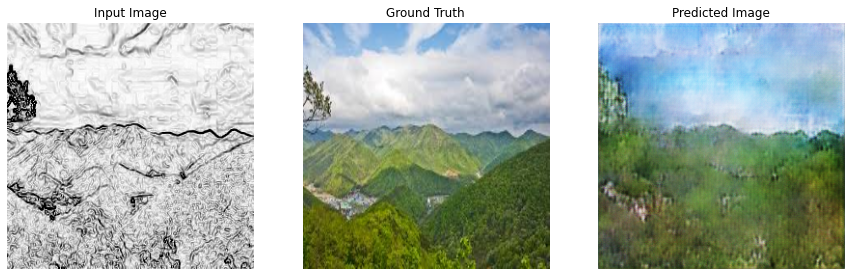

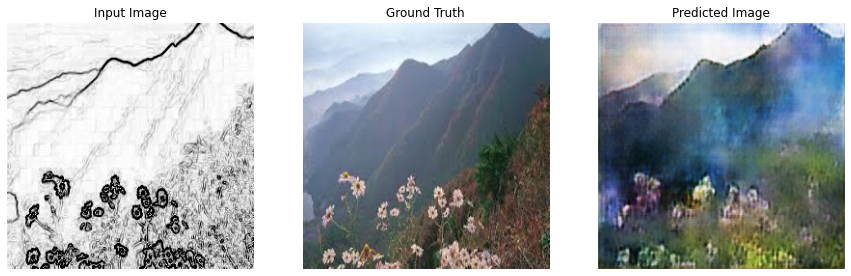

In [ ]:
for example_input, example_target in val_dataset.take(3):
    generate_images(generator, example_input, example_target)

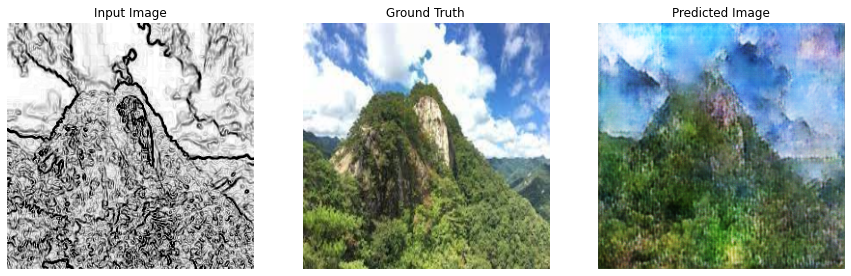

In [ ]:
for example_input, example_target in test_dataset.take(3):
    generate_images(generator, example_input, example_target)

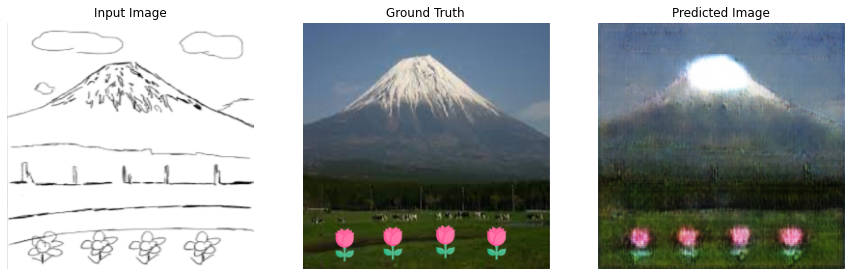

In [ ]:
for example_input, example_target in hand_dataset.take(-3):
    generate_images(generator, example_input, example_target)

In [ ]:
generator.save('G_GAN_Mountain_Model_epoch_v1.1_150.h5')
discriminator.save('D_GAN_Mountain_Model_epoch_v1.1_150.h5')